<p style="padding: 10px;
          font-size:50px;
          font-weight: bolder;
          color: rgba(124, 203, 234, 0.75)">
    Laboratory Task 1
</p>

<a name="000" style="color: black">
    <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
        Table of Contents
    </p>
</a>

<div style="padding: 20px;
            margin-top: 20px;
            color: black;
            background: rgba(124,203,234,0.25)">
    <ol>
        <li><a href="#001">Data Preprocessing</a></li>
        <li><a href="#002">Option 1: Data for Regression</a></li>
        <li><a href="#003">Option 2: Data for Time Series</a></li>
    </ol>
</div>

In [1]:
# !pip install holidays geopy

In [2]:
import datetime
import numpy as np
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
from geopy.geocoders import Nominatim
import seaborn as sns
import holidays
import warnings

from sklearn.utils import resample, shuffle

warnings.filterwarnings(action="ignore")
sns.set_theme(style="whitegrid", palette="pastel")
%matplotlib inline

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="001" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Data Preprocessing
        </p>
    </a>
</blockquote>

The dataset of one popular social network includes more than 8.5 million records with meta-information of publications over 13 months (January 2019 to February 2020).

Each publication is described by the following meta-information:
- **lon**, **lat** – geoposition coordinates rounded up to a 250x250 meter polygon (geographical longitude and latitude, respectively)
- **timestamp** – timestamp of the publication accurate to one hour
- **likescount** – number of "likes" in the publication
- **commentscount** – number of comments of the publication
- **symbols_cnt** – number of all symbols in the publication
- **words_cnt** – number of words (meaningful, not counting special characters and other meta-information)
- **hashtags_cnt** – number of hashtags
- **mentions_cnt** – the number of mentions of other users
- **links_cnt** – number of links
- **emoji_cnt** – number of emoji

In [3]:
train_data = pd.read_csv("src\\train_data.csv")
test_data = pd.read_csv("src\\test.csv")
valid_data = pd.read_csv("src\\valid.csv")

train_data.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...


In [4]:
def get_report(data: pd.DataFrame) -> None:
    print(f"Dataset shape: {data.shape}")
    print(f"Number of unique points: {data['point'].nunique()}")
    print(f"Number of duplicates: {data.duplicated().sum()}")
    print(f"Number of NaNs: {data.isna().sum().max()}")
    print(f"Data types: {data.dtypes.unique()} \n")

for data in [train_data, test_data, valid_data]:
    get_report(data=data)

Dataset shape: (8526526, 12)
Number of unique points: 7041
Number of duplicates: 69750
Number of NaNs: 0
Data types: [dtype('int64') dtype('float64') dtype('O')] 

Dataset shape: (700, 6)
Number of unique points: 149
Number of duplicates: 0
Number of NaNs: 0
Data types: [dtype('int64') dtype('float64') dtype('O')] 

Dataset shape: (709, 6)
Number of unique points: 155
Number of duplicates: 0
Number of NaNs: 0
Data types: [dtype('int64') dtype('float64') dtype('O')] 



In [5]:
nominatim = Nominatim(user_agent="tutorial")
location = nominatim.geocode("Saint Petersburg, Russia").raw
print(location["boundingbox"])

['59.7441481', '60.0907368', '30.0433427', '30.5671662']


In [6]:
def filter_geo(data: pd.DataFrame, loc: dict) -> pd.DataFrame:
    min_lat, max_lat, min_lon, max_lon = np.array(loc["boundingbox"]).astype(float)
    
    data = data[(data["lon"] <= max_lon) & (data["lon"] >= min_lon)]
    data = data[(data["lat"] <= max_lat) & (data["lat"] >= min_lat)]
    
    return data

train_data = filter_geo(data=train_data, loc=location)
print(f"Dataset shape: {train_data.shape}")
test_data = filter_geo(data=test_data, loc=location)
print(f"Dataset shape: {test_data.shape}")
valid_data = filter_geo(data=valid_data, loc=location)
print(f"Dataset shape: {valid_data.shape}")

Dataset shape: (8447276, 12)
Dataset shape: (700, 6)
Dataset shape: (686, 6)


In [7]:
useless_cols = [
    "likescount", "commentscount", "symbols_cnt",
    "words_cnt", "hashtags_cnt", "mentions_cnt",
    "links_cnt", "emoji_cnt", "timestamp"
]

train_data["sum"] = 1
train_data["datetime"] = pd.to_datetime(train_data["timestamp"], unit="s")
train_data.drop(useless_cols, axis=1, inplace=True)
train_data = train_data.groupby(by=["datetime", "point", "lon", "lat"], as_index=False).sum()
print(f"Dataset shape: {train_data.shape}")
train_data.head()

Dataset shape: (3623620, 5)


,datetime,point,lon,lat,sum
0,2019-01-01,0101000020E610000002BF48199F3F3E4010C569574E02...,30.248521,60.018016,1
1,2019-01-01,0101000020E610000002BF48199F3F3E40586790FFD8EC...,30.248521,59.850372,1
2,2019-01-01,0101000020E61000000614FD60523D3E400086058A8CFB...,30.239538,59.965226,1
3,2019-01-01,0101000020E61000000614FD60523D3E4074DD5BB2DBED...,30.239538,59.858267,2
4,2019-01-01,0101000020E61000000614FD60523D3E40D800D455BF04...,30.239538,60.037089,1


In [8]:
train_data["lon"] = train_data["lon"].astype(np.float32)
train_data["lat"] = train_data["lat"].astype(np.float32)
train_data["sum"] = train_data["sum"].astype(np.int32)

train_data.to_csv("src\\cleaned_train.csv", index=False)
train_data.describe()

,lon,lat,sum
count,3.623620e+06,3.623620e+06,3.623620e+06
mean,3.141553e+01,6.048265e+01,2.331170e+00
std,1.092243e+00,5.499635e-01,4.160512e+00
min,3.008907e+01,5.980635e+01,1.000000e+00
25%,3.028445e+01,5.990897e+01,1.000000e+00
50%,3.032263e+01,5.993599e+01,1.000000e+00
75%,3.036755e+01,5.996748e+01,2.000000e+00
max,3.056518e+01,6.007296e+01,6.000000e+02


In [9]:
test_data["datetime"] = pd.to_datetime(test_data["hour"], unit="s")
test_data["lon"] = test_data["lon"].astype(np.float32)
test_data["lat"] = test_data["lat"].astype(np.float32)
test_data["sum"] = test_data["sum"].astype(np.int32)
test_data["error"] = test_data["error"].astype(np.float32)

test_data.to_csv("src\\cleaned_test.csv", index=False)
test_data.describe()

,hour,lat,lon,sum,error
count,7.000000e+02,700.000000,700.000000,700.000000,700.000000
mean,1.581748e+09,59.930992,30.331795,9.682857,2.620671
std,7.180874e+05,0.040814,0.073457,6.430390,4.055030
min,1.580537e+09,59.831192,30.142969,5.000000,0.004735
25%,1.581156e+09,59.921360,30.295683,5.000000,0.421402
50%,1.581741e+09,59.932613,30.322632,7.000000,1.269158
75%,1.582391e+09,59.940768,30.358564,11.000000,3.754735
max,1.583010e+09,60.039333,30.515770,40.000000,38.754734


In [10]:
valid_data["datetime"] = pd.to_datetime(valid_data["hour"], unit="s")
valid_data["lon"] = valid_data["lon"].astype(np.float32)
valid_data["lat"] = valid_data["lat"].astype(np.float32)
valid_data["sum"] = valid_data["sum"].astype(np.int32)
valid_data["error"] = valid_data["error"].astype(np.float32)

valid_data.to_csv("src\\cleaned_valid.csv", index=False)
valid_data.describe()

,hour,lat,lon,sum,error
count,6.860000e+02,686.000000,686.000000,686.000000,686.000000
mean,1.581783e+09,59.933338,30.327589,9.848397,2.644808
std,7.202487e+05,0.041569,0.068056,6.471299,3.868672
min,1.580548e+09,59.828934,30.142969,5.000000,0.003861
25%,1.581175e+09,59.921360,30.297928,6.000000,0.467870
50%,1.581799e+09,59.932613,30.322632,7.000000,1.408210
75%,1.582408e+09,59.949486,30.356319,11.000000,3.754735
max,1.583014e+09,60.039333,30.535982,40.000000,38.754734


<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="002" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Option 1: Data for Regression
        </p>
    </a>
</blockquote>

In [3]:
train_data = pd.read_csv("src\\cleaned_train.csv", parse_dates=["datetime"],
    dtype={"lon": np.float32, "lat": np.float32, "sum": np.int32})
test_data = pd.read_csv("src\\cleaned_test.csv", parse_dates=["datetime"],
    dtype={"lon": np.float32, "lat": np.float32, "sum": np.int32})
valid_data = pd.read_csv("src\\cleaned_valid.csv", parse_dates=["datetime"],
    dtype={"lon": np.float32, "lat": np.float32, "sum": np.int32})

train_data.head()

,datetime,point,lon,lat,sum
0,2019-01-01,0101000020E610000002BF48199F3F3E4010C569574E02...,30.248522,60.018017,1
1,2019-01-01,0101000020E610000002BF48199F3F3E40586790FFD8EC...,30.248522,59.850372,1
2,2019-01-01,0101000020E61000000614FD60523D3E400086058A8CFB...,30.239538,59.965225,1
3,2019-01-01,0101000020E61000000614FD60523D3E4074DD5BB2DBED...,30.239538,59.858269,2
4,2019-01-01,0101000020E61000000614FD60523D3E40D800D455BF04...,30.239538,60.037090,1


In [4]:
train_data["year"] = train_data["datetime"].dt.year
train_data["month"] = train_data["datetime"].dt.month
train_data["day"] = train_data["datetime"].dt.day
train_data["hour"] = train_data["datetime"].dt.hour
train_data["weekday"] = train_data["datetime"].dt.weekday
train_data["weekend"] = train_data["datetime"].dt.weekday // 5

In [5]:
ru_holidays = holidays.country_holidays("RU", years=[2019, 2020])
date(2019, 10, 31) in ru_holidays

False

In [6]:
class HalloweenHolidays(holidays.HolidayBase):
    def _populate(self, year):
        self[date(year, 10, 31)] = "Halloween"

class ChristmasHolidays(holidays.HolidayBase):
    def _populate(self, year):
        self[date(year, 12, 25)] = "Christmas"

class ValentinesHolidays(holidays.HolidayBase):
    def _populate(self, year):
        self[date(year, 2, 14)] = "Valentine's Day"

class FoolsHolidays(holidays.HolidayBase):
    def _populate(self, year):
        self[date(year, 4, 1)] = "Fool's Day"

class ChineseHolidays(holidays.HolidayBase):
    def _populate(self, year):
        self[date(2019, 2, 5)] = "Chinese New Year"
        self[date(2020, 1, 25)] = "Chinese New Year"

In [7]:
ru_holidays += HalloweenHolidays()
ru_holidays += ChristmasHolidays()
ru_holidays += ValentinesHolidays()
ru_holidays += FoolsHolidays()
ru_holidays += ChineseHolidays()

date(2019, 10, 31) in ru_holidays

True

In [8]:
train_data["holiday"] = train_data["datetime"].apply(lambda row: int(row in ru_holidays))

In [9]:
point_ids = train_data["point"].unique().tolist()
train_data["point_id"] = train_data["point"].apply(lambda row: point_ids.index(row))
train_data.drop(["point", "datetime"], axis=1, inplace=True)
train_data.head()

,lon,lat,sum,year,month,day,hour,weekday,weekend,holiday,point_id
0,30.248522,60.018017,1,2019,1,1,0,1,0,1,0
1,30.248522,59.850372,1,2019,1,1,0,1,0,1,1
2,30.239538,59.965225,1,2019,1,1,0,1,0,1,2
3,30.239538,59.858269,2,2019,1,1,0,1,0,1,3
4,30.239538,60.037090,1,2019,1,1,0,1,0,1,4


In [10]:
test_data["year"] = test_data["datetime"].dt.year
test_data["month"] = test_data["datetime"].dt.month
test_data["day"] = test_data["datetime"].dt.day
test_data["hour"] = test_data["datetime"].dt.hour
test_data["weekday"] = test_data["datetime"].dt.weekday
test_data["weekend"] = test_data["datetime"].dt.weekday // 5
test_data["holiday"] = test_data["datetime"].apply(lambda row: int(row in ru_holidays))
test_data["point_id"] = test_data["point"].apply(lambda row: point_ids.index(row))
test_data.drop(["point", "datetime"], axis=1, inplace=True)
test_data.head()

,hour,lat,lon,sum,error,year,month,day,weekday,weekend,holiday,point_id
0,10,59.934864,30.331615,7,0.370265,2020,2,26,2,0,0,148
1,11,59.940487,30.329370,6,0.754735,2020,2,17,0,0,0,208
2,16,59.905598,30.297928,5,3.754735,2020,2,12,2,0,0,1417
3,13,59.921360,30.356319,16,4.088069,2020,2,12,2,0,0,192
4,13,59.939362,30.315895,10,2.088068,2020,2,15,5,1,0,103


In [11]:
valid_data["year"] = valid_data["datetime"].dt.year
valid_data["month"] = valid_data["datetime"].dt.month
valid_data["day"] = valid_data["datetime"].dt.day
valid_data["hour"] = valid_data["datetime"].dt.hour
valid_data["weekday"] = valid_data["datetime"].dt.weekday
valid_data["weekend"] = valid_data["datetime"].dt.weekday // 5
valid_data["holiday"] = valid_data["datetime"].apply(lambda row: int(row in ru_holidays))
valid_data["point_id"] = valid_data["point"].apply(lambda row: point_ids.index(row))
valid_data.drop(["point", "datetime"], axis=1, inplace=True)
valid_data.head()

,hour,lat,lon,sum,error,year,month,day,weekday,weekend,holiday,point_id
0,9,59.926987,30.318140,5,0.421402,2020,2,23,6,1,1,254
1,19,59.924736,30.241783,14,0.310291,2020,2,20,3,0,0,320
2,15,60.002300,30.295683,5,3.754735,2020,2,9,6,1,0,313
3,17,59.935989,30.324879,7,0.504735,2020,2,17,0,0,0,283
4,5,59.933739,30.306911,14,1.554735,2020,2,27,3,0,0,109


In [12]:
train_data.to_csv("src\\reg_train.csv", index=False)
test_data.to_csv("src\\reg_test.csv", index=False)
valid_data.to_csv("src\\reg_valid.csv", index=False)

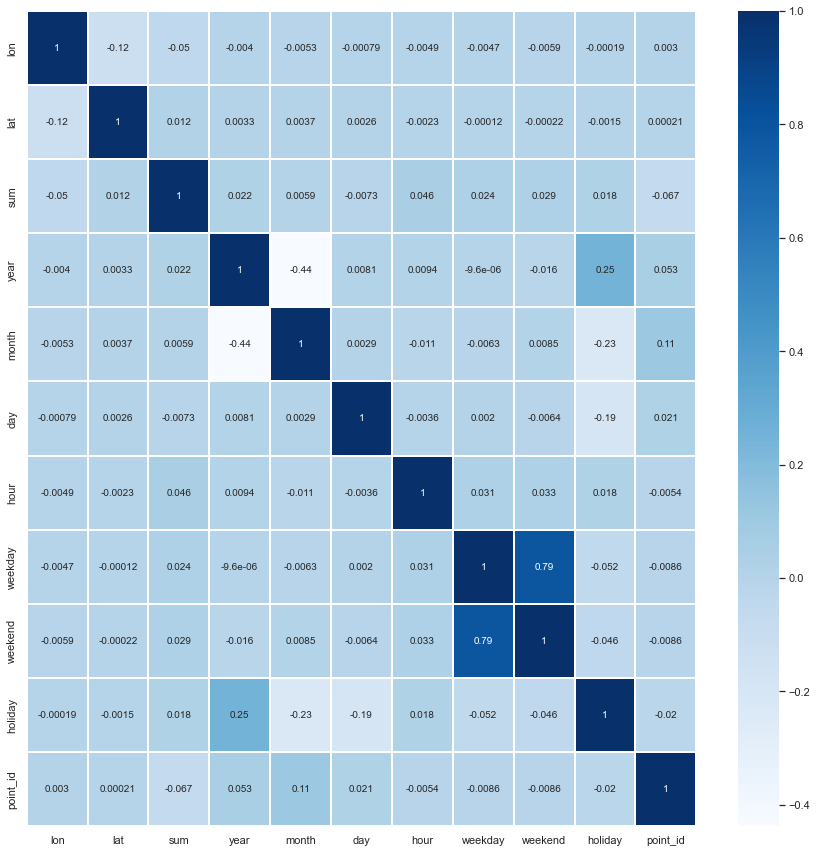

In [13]:
figure, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(train_data.corr(), cmap="Blues", annot=True, linewidths=0.25)
plt.show()

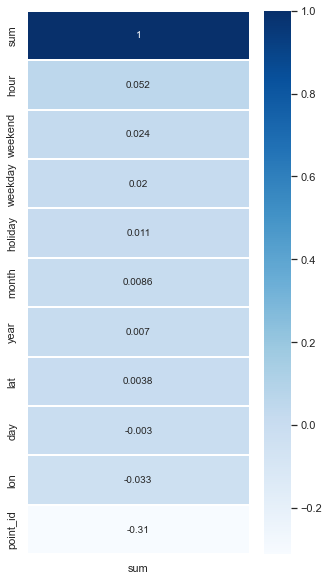

In [14]:
figure, ax = plt.subplots(1, 1, figsize=(5, 10))
sns.heatmap(
    train_data
        .corr(method="spearman")[["sum"]]
        .sort_values(by="sum", ascending=False),
    cmap="Blues",
    annot=True,
    linewidths=0.25
)
plt.show()

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="003" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Option 2: Data for Time Series
        </p>
    </a>
</blockquote>

In [3]:
train_data = pd.read_csv("src\\cleaned_train.csv", parse_dates=["datetime"], encoding="cp1251")
train_data = train_data[["datetime", "sum"]].sort_values(by="datetime")

test_data = pd.read_csv("src\\cleaned_test.csv", parse_dates=["datetime"], encoding="cp1251")
test_data = test_data[["datetime", "sum"]].sort_values(by="datetime")

valid_data = pd.read_csv("src\\cleaned_valid.csv", parse_dates=["datetime"], encoding="cp1251")
valid_data = valid_data[["datetime", "sum"]].sort_values(by="datetime")

train_data.head()

,datetime,sum
0,2019-01-01,1
152,2019-01-01,1
153,2019-01-01,1
154,2019-01-01,7
155,2019-01-01,1


In [4]:
train_data = train_data.groupby(by=["datetime"]).sum()
test_data = test_data.groupby(by=["datetime"]).sum()
valid_data = valid_data.groupby(by=["datetime"]).sum()

train_data.head()

,sum
datetime,
2019-01-01 00:00:00,479
2019-01-01 01:00:00,363
2019-01-01 02:00:00,244
2019-01-01 03:00:00,141
2019-01-01 04:00:00,85


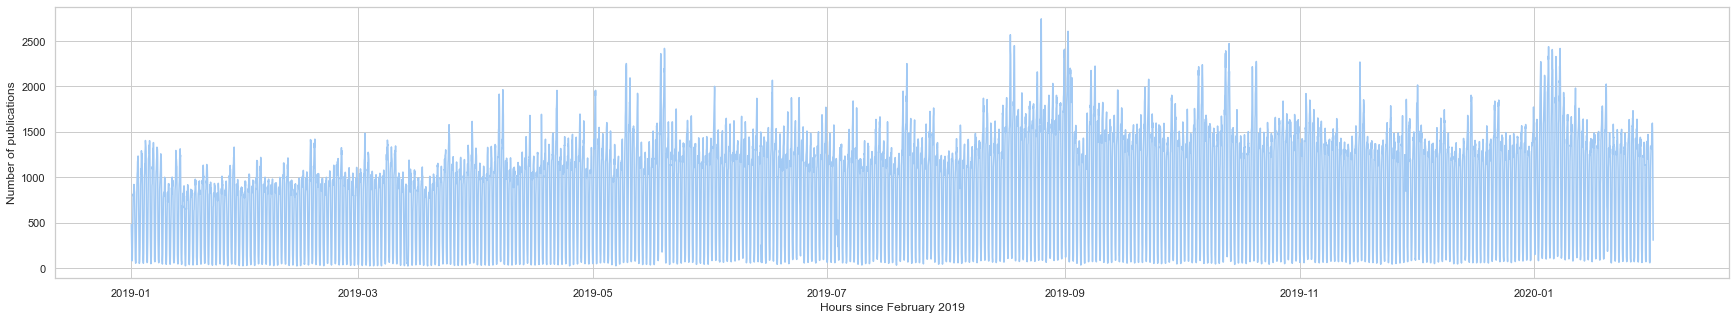

In [5]:
plt.figure(figsize=(30, 5))
plt.plot(train_data)
plt.ylabel("Number of publications")
plt.xlabel("Hours since February 2019")
plt.show()

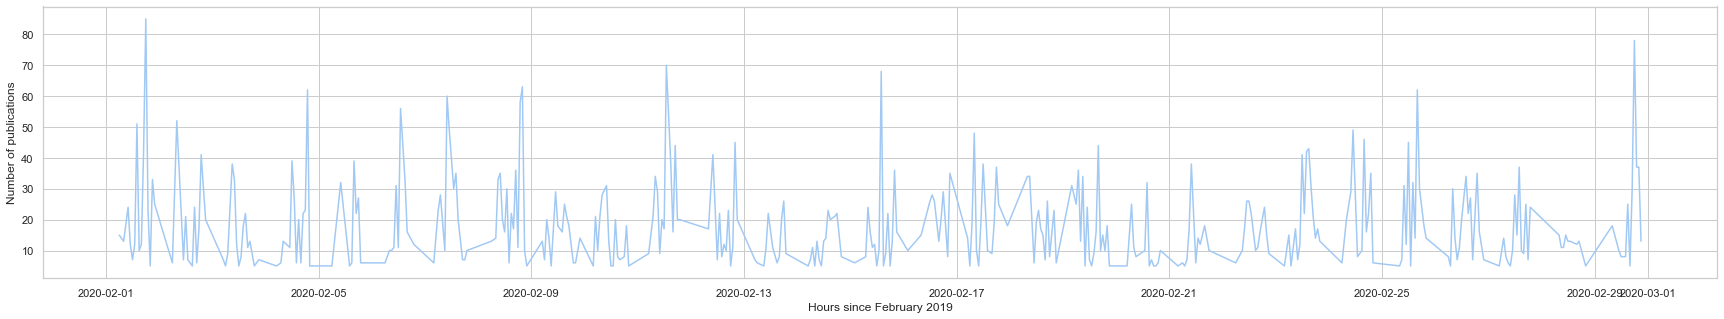

In [6]:
plt.figure(figsize=(30, 5))
plt.plot(test_data)
plt.ylabel("Number of publications")
plt.xlabel("Hours since February 2019")
plt.show()

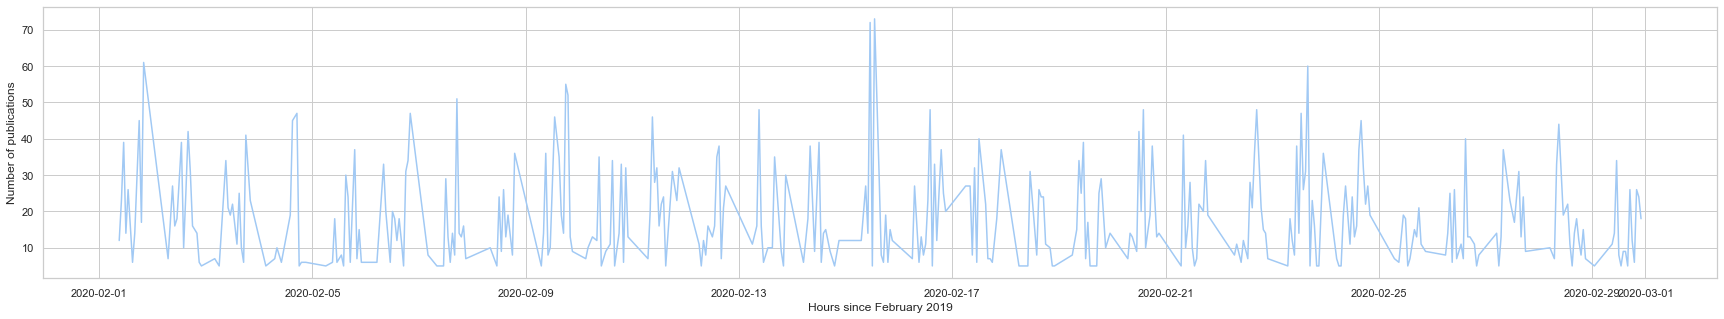

In [7]:
plt.figure(figsize=(30, 5))
plt.plot(valid_data)
plt.ylabel("Number of publications")
plt.xlabel("Hours since February 2019")
plt.show()

In [8]:
train_data.to_csv("src\\time_train.csv", index=True)
test_data.to_csv("src\\time_test.csv", index=True)
valid_data.to_csv("src\\time_valid.csv", index=True)